# Explore efficiency of ocean alkalinity enhancement



In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from functools import partial
from toolz import curry

import numpy as np
import dask

import pandas as pd
import xarray as xr

import matplotlib.pyplot as plt

import onets_lab

## Load GLODAP Observations

To understand the efficiency of additional carbon uptake, we first examine the distribution of DIC and alkalinty at the ocean surface.

In [3]:
ds = onets_lab.open_glodap().isel(depth=0, drop=True)[['DIC', 'ALK', 'SALT', 'TEMP']]
ds

<xarray.Dataset>
Dimensions:  (lat: 180, lon: 360)
Coordinates:
  * lon      (lon) float64 20.5 21.5 22.5 23.5 24.5 ... 376.5 377.5 378.5 379.5
  * lat      (lat) float64 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5
Data variables:
    DIC      (lat, lon) float64 ...
    ALK      (lat, lon) float64 ...
    SALT     (lat, lon) float64 ...
    TEMP     (lat, lon) float64 ...
Attributes:
    Description:          1 X 1 global mapped field of anthropogenic carbon c...
    Created:              Created by Siv K. Lauvset on 12-May-2016 18:48:16
    Institution name:     University of Bergen
    Contact information:  siv.lauvset@uib.no; are.olsen@uib.no
    Citation:             Cite as: Lauvset, Siv K., Key, Robert M., Olsen, Ar...

### Define a range of representative concentrations

Plot zonal-mean distributions of DIC and ALK and pick out some representative conditions.


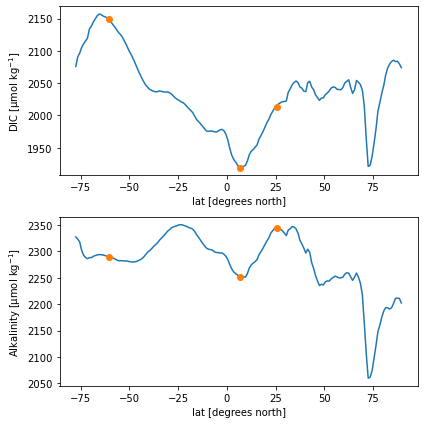

In [4]:
fig, axs = plt.subplots(2, 1, figsize=(6, 6))

with xr.set_options(keep_attrs=True):
    ds.DIC.mean('lon').plot(ax=axs[0])
    ds.ALK.mean('lon').plot(ax=axs[1])

    
lat_select = np.array([-60.5, 25.5, 6.5])
with xr.set_options(keep_attrs=True):
    ds_surf = ds.mean('lon').sel(lat=lat_select)

axs[0].plot(lat_select, ds_surf.DIC, 'o')
axs[1].plot(lat_select, ds_surf.ALK, 'o')

fig.tight_layout()

Compute pCO$_2$ and convert to `DataFrame` for convenience.

In [5]:
# convert to volumetric units
rho_ref = 1026.0

Xco2atm = 375.0
Patm = 1.0

for v in ds_surf.data_vars:
    if v in ['DIC', 'ALK']:
        ds_surf[v] = ds_surf[v] * rho_ref / 1.0e3 # µmol/kg --> mmol/m^3


co2aq = onets_lab.co2calc.calc_co2(
    S=ds_surf.SALT,
    T=ds_surf.TEMP,
    DIC=ds_surf.DIC,
    ALK=ds_surf.ALK,
)
co2sol = onets_lab.co2calc.co2sol(ds_surf.SALT, ds_surf.TEMP)

ds_surf['pco2'] = 1.0e6 * co2aq / co2sol

# compute equilibrium DIC under Xco2atm 
ds_surf['dic_eq'] = onets_lab.co2calc.calc_dic(
            ds_surf.ALK,
            Xco2atm * Patm,
            ds_surf.SALT,
            ds_surf.TEMP,
        )

df_exp = ds_surf.to_dataframe().reset_index()
df_exp = df_exp.rename(columns={k: k.lower() for k in df_exp.columns})
df_exp

,lat,dic,alk,salt,temp,pco2,dic_eq
0,-60.5,2204.625691,2349.410255,33.897333,1.399264,346.747746,2216.299581
1,25.5,2065.963975,2404.827201,35.651121,23.631589,356.350465,2077.314744
2,6.5,1969.227371,2310.004952,34.273102,28.154523,378.284875,1967.306094


## Generate box model forcing dataset

First, set the alkalinity forcing (applied as surface flux) to a representative value. Here we use the global flux recommended in the CDR-MIP experiments documented in Keller et al. ([2018](https://gmd.copernicus.org/articles/11/1133/2018/)). We use an approximate value for ocean area between 60°S-66°N to determine the areally normalized flux.

In [6]:
cdr_mip_global_flux = 0.14e15 # mol/yr
ocean_area = 3.269e+14 # m^2 
alk_flux_molm2yr = cdr_mip_global_flux / ocean_area # mol/m^2/yr
alk_flux_mmolm2s = alk_flux_molm2yr / 365.0 / 86400.0 * 1.0e3 # mmol/m^2/s
alk_flux_mmolm2s

1.3580210699685049e-05

Set constant forcings

In [7]:
ds = xr.Dataset(
    dict(
        u10=xr.DataArray(
            np.arange(0.5, 15.5, 0.5),
            dims=('u10'),
            attrs={'long_name': 'Wind speed', 'units': 'm/s'},
        ),
        ventilation_flow=xr.DataArray(
            np.arange(0.5, 10.5, 0.5) * 1e6,
            dims=('ventilation_flow'),
            attrs={'long_name': 'Ventilation rate', 'units': 'm$^3$/s'},
        ),
        alk_flux=xr.DataArray(
            np.array([0.5, 1.0, 10.0]) * alk_flux_mmolm2s,
            dims=('alk_flux'),
            attrs={'long_name': 'Alkalinity forcing', 'units': 'mmol m$^{-2}$ s$^{-1}$'},
        ),
        h=xr.DataArray(
            np.array([100.0, 1000.0]),
            dims=('h'),
            attrs={'long_name': 'Mixed layer depth', 'units': 'm'},
        ),        
    )
)
df = ds.to_dataframe()

df['Xco2atm'] = Xco2atm
df['patm'] = Patm
df['lventilate'] = True
df['fice'] = 0.0
df['area'] = 10000000000.0

df

Xco2atm  patm  lventilate  fice  \
u10  ventilation_flow alk_flux h                                         
0.5  500000.0         0.000007 100.0     375.0   1.0        True   0.0   
                               1000.0    375.0   1.0        True   0.0   
                      0.000014 100.0     375.0   1.0        True   0.0   
                               1000.0    375.0   1.0        True   0.0   
                      0.000136 100.0     375.0   1.0        True   0.0   
...                                        ...   ...         ...   ...   
15.0 10000000.0       0.000007 1000.0    375.0   1.0        True   0.0   
                      0.000014 100.0     375.0   1.0        True   0.0   
                               1000.0    375.0   1.0        True   0.0   
                      0.000136 100.0     375.0   1.0        True   0.0   
                               1000.0    375.0   1.0        True   0.0   

                                               area  
u10  ventilation_flow alk_flux h                     
0.5  500000.0         0.000007 100.0   1.000000e+10  
                               1000.0  1.000000e+10  
                      0.000014 100.0   1.000000e+10  
                               1000.0  1.000000e+10  
                      0.000136 100.0   1.000000e+10  
...                                             ...  
15.0 10000000.0       0.000007 1000.0  1.000000e+10  
                      0.000014 100.0   1.000000e+10  
                               1000.0  1.000000e+10  
                      0.000136 100.0   1.000000e+10  
                               1000.0  1.000000e+10  

[3600 rows x 5 columns]

## Initialize box-model experiments

The control (`ctrl`) has no alkalinity flux, while `pert` applies the alkalinity forcing.

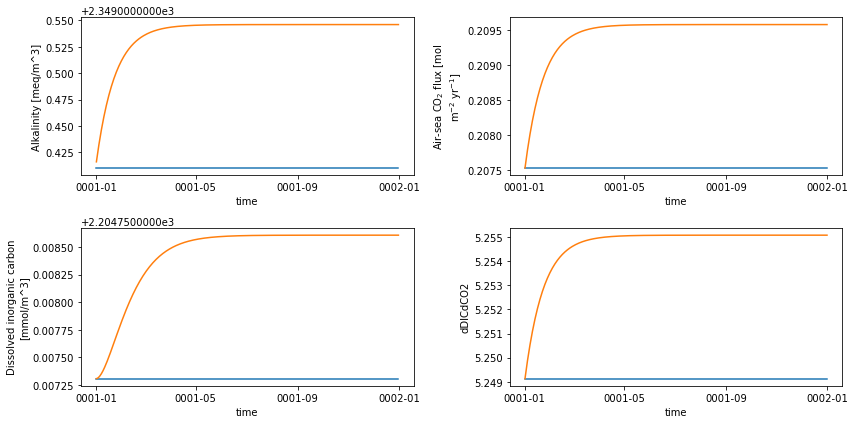

In [8]:
fig, axs = plt.subplots(2, 2, figsize=(12, 6))


i_loc = 0
bc_data = dict(dic=df_exp.loc[i_loc].dic, alk=df_exp.loc[i_loc].alk)
other_state_data = {k: df_exp.loc[i_loc][k] for k in ['salt', 'temp']}


# pick a row
i_row = 0
ndx_kwargs = {k: v for k, v in zip(list(df.index.names), df.iloc[i_row].name)}
other_kwargs = dict(df.iloc[i_row])

# initial conditions and model parameters
init_kwargs = dict(
    **ndx_kwargs,
    **other_kwargs,
    **other_state_data,
    tracer_boundary_conc=bc_data,
)


# run the control simulation
ds_ctrl = onets_lab.sim_single_box(
    365, ic_data=bc_data, do_spinup=True, lapply_alk_flux=False, **init_kwargs, 
).compute()


# run the perturbation simulation
ic_data=dict(dic=ds_ctrl.dic.isel(time=0), alk=ds_ctrl.alk.isel(time=0))

ds_pert = onets_lab.sim_single_box(
    365, ic_data, do_spinup=False, lapply_alk_flux=True, **init_kwargs,
).compute()

# plot
ds_ctrl.alk.plot(label='CTRL', ax=axs[0, 0])
ds_ctrl.dic.plot(label='CTRL', ax=axs[1, 0])
ds_ctrl.fgco2.plot(label='CTRL', ax=axs[0, 1])
ds_ctrl.dDICdCO2.plot(label='CTRL', ax=axs[1, 1])

# plot
ds_pert.alk.plot(label='PERT', ax=axs[0, 0])
ds_pert.dic.plot(label='PERT', ax=axs[1, 0])
ds_pert.fgco2.plot(label='PERT', ax=axs[0, 1])
ds_pert.dDICdCO2.plot(label='PERT', ax=axs[1, 1])

plt.tight_layout();

In [9]:
from dask.distributed import Client, LocalCluster
cluster = LocalCluster()
client = Client(cluster)
client

2022-05-09 10:35:11,836 - distributed.diskutils - INFO - Found stale lock file and directory '/Users/mclong/codes/onets-lab/docs/source/dask-worker-space/worker-g0n79k37', purging


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 4
Total threads: 8,Total memory: 16.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:61064,Workers: 4
Dashboard: http://127.0.0.1:8787/status,Total threads: 8
Started: Just now,Total memory: 16.00 GiB
Comm: tcp://127.0.0.1:61079,Total threads: 2
Dashboard: http://127.0.0.1:61083/status,Memory: 4.00 GiB
Nanny: tcp://127.0.0.1:61069,


In [ ]:
%%time

i_loc = 0
bc_data = dict(dic=df_exp.loc[i_loc].dic, alk=df_exp.loc[i_loc].alk)
other_state_data = {k: df_exp.loc[i_loc][k] for k in ['salt', 'temp']}

dsets_ctrl = []
dsets_pert = []
for i_row in range(len(df)):

    # get index data for this row
    ndx_kwargs = {k: v for k, v in zip(list(df.index.names), df.iloc[i_row].name)}
    other_kwargs = dict(df.iloc[i_row])

    # initial conditions and model parameters
    init_kwargs = dict(
        **ndx_kwargs,
        **other_kwargs,
        **other_state_data,
        tracer_boundary_conc=bc_data,
    )

    # run the control simulation
    ds_ctrl = onets_lab.sim_single_box(
        1, ic_data=bc_data, do_spinup=True, lapply_alk_flux=False, **init_kwargs, 
    ).compute()


    # run the perturbation simulation
    ds_pert = onets_lab.sim_single_box(
        1, ic_data=bc_data, do_spinup=True, lapply_alk_flux=True, **init_kwargs,
    ).compute()        

    dsets_ctrl.append(ds_ctrl)
    dsets_pert.append(ds_pert)


dsets_ctrl = dask.compute(*dsets_ctrl)
dsets_pert = dask.compute(*dsets_pert)

/Users/mclong/miniconda3/envs/onets/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
/Users/mclong/miniconda3/envs/onets/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
/Users/mclong/miniconda3/envs/onets/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


In [45]:
%%time
n = 0
for i, u10 in enumerate(ds.u10):
    for j, vent_rate in enumerate(ds.vent_rate):
        for v in varlist:
            ds[v].data[0, i, j] = dsets_ctrl[n][v].isel(time=-1)
            ds[v].data[1, i, j] = dsets_pert[n][v].isel(time=-1)
        n += 1
ds

CPU times: user 1.4 s, sys: 26.8 ms, total: 1.43 s
Wall time: 1.43 s


<xarray.Dataset>
Dimensions:         (exp: 2, u10: 30, vent_rate: 20)
Coordinates:
  * exp             (exp) <U4 'ctrl' 'pert'
  * u10             (u10) float64 0.5 1.0 1.5 2.0 2.5 ... 13.5 14.0 14.5 15.0
  * vent_rate       (vent_rate) float64 5e+05 1e+06 1.5e+06 ... 9.5e+06 1e+07
Data variables:
    pco2            (exp, u10, vent_rate) float64 356.4 356.4 ... 357.7 357.7
    fgco2           (exp, u10, vent_rate) float64 0.03554 0.03558 ... 29.76
    pH              (exp, u10, vent_rate) float64 8.1 8.1 8.1 ... 8.098 8.098
    revelle_factor  (exp, u10, vent_rate) float64 12.38 12.38 ... 12.4 12.4
    dDICdCO2        (exp, u10, vent_rate) float64 16.07 16.07 ... 16.0 16.0
    xkw             (exp, u10, vent_rate) float64 2.079e-06 ... 0.001871
    dic             (exp, u10, vent_rate) float64 2.066e+03 ... 2.067e+03
    alk             (exp, u10, vent_rate) float64 2.405e+03 ... 2.405e+03

In [37]:
ds = ds_pert - ds_ctrl
ds

<xarray.Dataset>
Dimensions:         (u10: 30, vent_rate: 20)
Coordinates:
  * u10             (u10) float64 0.5 1.0 1.5 2.0 2.5 ... 13.5 14.0 14.5 15.0
  * vent_rate       (vent_rate) float64 5e+05 1e+06 1.5e+06 ... 9.5e+06 1e+07
Data variables:
    pco2            (u10, vent_rate) float64 -3.44 -1.728 ... -0.1682 -0.1605
    fgco2           (u10, vent_rate) float64 0.006568 0.003299 ... 0.2891 0.2758
    pH              (u10, vent_rate) float64 0.003792 0.0019 ... 0.0001771
    revelle_factor  (u10, vent_rate) float64 -0.04764 -0.02391 ... -0.002239
    dDICdCO2        (u10, vent_rate) float64 0.2193 0.1095 ... 0.01062 0.01013
    xkw             (u10, vent_rate) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    dic             (u10, vent_rate) float64 0.004167 0.001046 ... 0.008745
    alk             (u10, vent_rate) float64 2.716 1.358 ... 0.1429 0.1358

In [39]:
forcing_data

,u10_data,salt_data,temp_data,patm_data,alk_flux_data,fice_data,h_data,ncp_data,Xco2atm_data,area_data
0,7.5,33.897333,1.399264,1.0,0.000136,0.0,100.0,0.0,375.0,1.000000e+10
1,7.5,35.651121,23.631589,1.0,0.000136,0.0,100.0,0.0,375.0,1.000000e+10
2,7.5,34.273102,28.154523,1.0,0.000136,0.0,100.0,0.0,375.0,1.000000e+10


In [49]:
#ds['vent_timescale'] = forcing_data.loc[i_row]['h_data'] * forcing_data.loc[i_row]['area_data']  / ds.vent_rate / 86000.0
#ds['gasex_timescale'] = forcing_data.loc[i_row]['h_data'] / onets_lab.gasex.gas_transfer_velocity(ds.u10, forcing_data.loc[i_row]['temp_data'])
#ds

<xarray.Dataset>
Dimensions:          (exp: 2, u10: 30, vent_rate: 20)
Coordinates:
  * exp              (exp) <U4 'ctrl' 'pert'
  * u10              (u10) float64 0.5 1.0 1.5 2.0 2.5 ... 13.5 14.0 14.5 15.0
  * vent_rate        (vent_rate) float64 5e+05 1e+06 1.5e+06 ... 9.5e+06 1e+07
Data variables:
    pco2             (exp, u10, vent_rate) float64 356.4 356.4 ... 357.7 357.7
    fgco2            (exp, u10, vent_rate) float64 0.03554 0.03558 ... 29.76
    pH               (exp, u10, vent_rate) float64 8.1 8.1 8.1 ... 8.098 8.098
    revelle_factor   (exp, u10, vent_rate) float64 12.38 12.38 ... 12.4 12.4
    dDICdCO2         (exp, u10, vent_rate) float64 16.07 16.07 ... 16.0 16.0
    xkw              (exp, u10, vent_rate) float64 2.079e-06 ... 0.001871
    dic              (exp, u10, vent_rate) float64 2.066e+03 ... 2.067e+03
    alk              (exp, u10, vent_rate) float64 2.405e+03 ... 2.405e+03
    vent_timescale   (vent_rate) float64 23.26 11.63 7.752 ... 1.292 1.224 1.163
    gasex_timescale  (u10) float64 4.811e+07 1.203e+07 ... 5.72e+04 5.345e+04

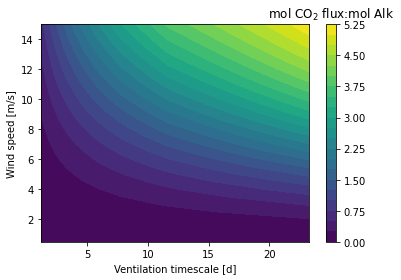

In [50]:
fig, ax = plt.subplots()
cf = ax.contourf(ds.vent_timescale, ds.u10, ds.diff('exp').squeeze().fgco2 / alk_flux_molm2yr, levels=20)
cb = fig.colorbar(cf)
ax.set_xlabel('Ventilation timescale [d]')
ax.set_ylabel('Wind speed [m/s]');

cb.ax.set_title('mol CO$_2$ flux:mol Alk');